In [2]:
import numpy as np


In [1]:
sc.master

'local[*]'

In [3]:
filename = './USA-road-d.NY.co/USA-road-d.NY.co' # txt文件和当前脚本在同一目录下，所以不用写具体路径
Efield = []
x_list = []
y_list = []
with open(filename, 'r') as file_to_read:
    count = 0
    while True:
        item = []
        lines = file_to_read.readline() # 整行读取数据
        if not lines:
            break
        v, id, x_loc, y_loc = [i for i in lines.split()] # 将整行数据分割处理，如果分割符是空格，括号里就不用传入参数，如果是逗号， 则传入‘，'字符。
        item.append(int(id))  # 添加新读取的数据
        item.append(int(x_loc))
        item.append(int(y_loc))
        Efield.append(item)
        x_list.append(int(x_loc))
        y_list.append(int(y_loc))
        count += 1
"""         if count % 1000 == 0:
            print("count:",count)
            print("item:",item) """
city_show_num = 4000
x_list = np.array(x_list)[0:city_show_num]
y_list = np.array(y_list)[0:city_show_num]

city_co = np.array(Efield)
print(city_co)
print(x_list)

[[        1 -73530767  41085396]
 [        2 -73530538  41086098]
 [        3 -73519366  41048796]
 ...
 [   264344 -73820681  40994683]
 [   264345 -73714376  41004205]
 [   264346 -73917690  41291980]]
[-73530767 -73530538 -73519366 ... -73515866 -73512266 -73511366]


## 读取图连通关系

In [4]:
filename = './USA-road-d.NY.gr/USA-road-d.NY.gr' # txt文件和当前脚本在同一目录下，所以不用写具体路径
Efield = []
with open(filename, 'r') as file_to_read:
    count = 0
    while True:
        item = []
        lines = file_to_read.readline() # 整行读取数据
        if not lines:
            break
        a, v_i, v_j, dis_ij = [i for i in lines.split()] # 将整行数据分割处理，如果分割符是空格，括号里就不用传入参数，如果是逗号， 则传入‘，'字符。
        item.append(int(v_i))  # 添加新读取的数据
        item.append(int(v_j))
        item.append(int(dis_ij))
        Efield.append(item)
        count += 1
"""         if count % 1000 == 0:
            print("count:",count)
            print("item:",item)  """

dis_table = np.array(Efield)
print(len(dis_table))
print(dis_table)

733846
[[     1      2    803]
 [     2      1    803]
 [     3      4    158]
 ...
 [263813 263466    106]
 [261228 259707    389]
 [259707 261228    389]]


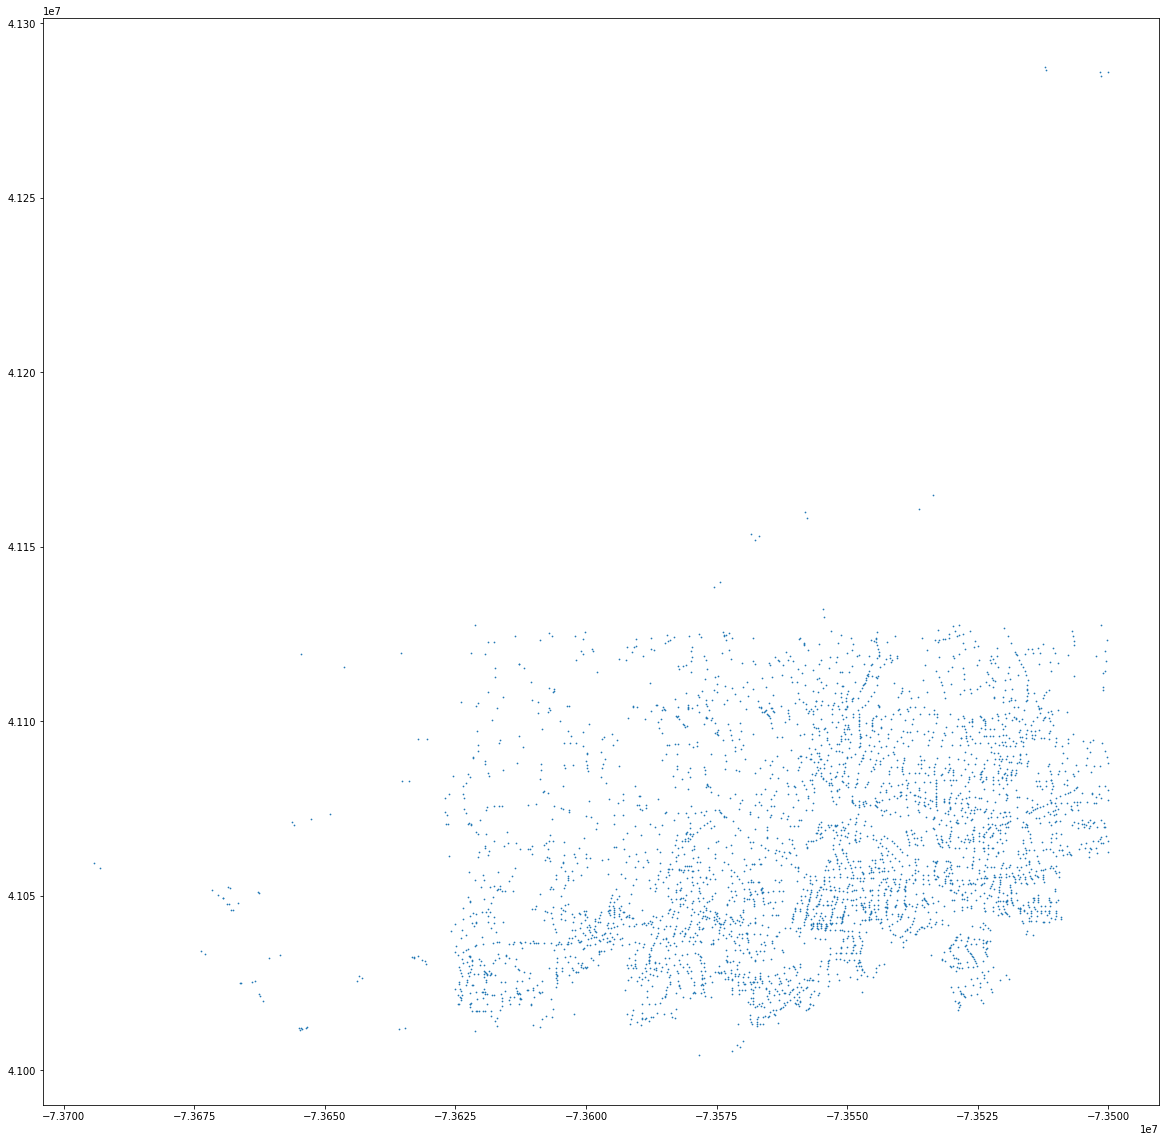

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))

""" for edge in dis_table[:1000]:
    x_1 = city_co[edge[0],1]
    x_2 = city_co[edge[1],1]
    X = [x_1, x_2]
    y_1 = city_co[edge[0],2]
    y_2 = city_co[edge[1],2]
    Y = [y_1, y_2]
    plt.plot(X, Y, color = 'r', linewidth = 0.1) """
# plt.savefig("map.png")
plt.scatter(x_list,y_list,s=0.5)
plt.show()

In [12]:
# -*- coding: utf-8 -*-
import random
import copy
import time
import numpy as np
import sys
import math
import tkinter #//GUI模块
import threading
import pandas as pd
from functools import reduce
from adjacency_list import Vertex,Graph

# 参数
'''
ALPHA:信息启发因子，值越大，则蚂蚁选择之前走过的路径可能性就越大
      ，值越小，则蚁群搜索范围就会减少，容易陷入局部最优
BETA:Beta值越大，蚁群越就容易选择局部较短路径，这时算法收敛速度会
     加快，但是随机性不高，容易得到局部的相对最优
'''
(ALPHA, BETA, RHO, Q) = (1.0,2.0,0.3,1000)
# 城市数，蚁群
(city_num, ant_num) = (4000,100)
distance_adja_graph = Graph()
pheromone_adja_graph = Graph()
for i in range(city_num):
    distance_adja_graph.addVertex(i)
    pheromone_adja_graph.addVertex(i)



In [6]:
#----------- 蚂蚁 -----------
class Ant(object):

    # 初始化
    def __init__(self,ID,target,start):

        self.ID = ID                 # ID
        self.target = target
        self.start = start
        self.__clean_data()          # 随机初始化出生点

    # 初始数据
    def __clean_data(self):

        self.path = []               # 当前蚂蚁的路径           
        self.total_distance = 0.0    # 当前路径的总距离
        self.move_count = 0          # 移动次数
        self.current_city = -1       # 当前停留的城市
        self.open_table_city = [True for i in range(city_num)] # 探索城市的状态

        #city_index = random.randint(0,city_num-1) # 随机初始出生点
        city_index = self.start
        self.current_city = city_index
        self.current_city_node = distance_adja_graph.vertList[self.current_city]
        #print('city:',self.current_city_node.getConnections())
        self.current_pheromone_node = pheromone_adja_graph.vertList[self.current_city]
        #print('pheromone:',self.current_pheromone_node.getConnections())
        self.path.append(city_index)
        self.open_table_city[city_index] = False
        self.move_count = 1

    # 选择下一个城市
    def __choice_next_city(self):

        next_city = -1
        select_citys_prob = [0.0 for i in range(city_num)]  #存储去下个城市的概率
        total_prob = 0.0
        #print('cityyyyyyy:',self.current_city_node.getConnections())
        for i in self.current_city_node.getConnections():
            if self.open_table_city[i.getId()]:
                try :
                    weight = int((abs(city_co[i.getId(),1] - city_co[self.target, 1]) + abs(city_co[i.getId(),2] - city_co[self.target, 2])) / 10)
                    #weight = self.current_city_node.getweight(distance_adja_graph.vertList[i.getId()])
                    pheromone = self.current_pheromone_node.getweight(pheromone_adja_graph.vertList[i.getId()])
                    
                    select_citys_prob[i.getId()] = pow(pheromone, ALPHA) * pow(1.0/(weight+1), BETA)
                    # 在城市的选择概率上，如果只与信息素有关，是否就一定程度上相当是于随机选择入手，然后会初始生成部分不太优的路径，然后根据评价指标评价后，得到不同的信息素分布。
                    # select_citys_prob[i.getId()] = pow(pheromone, ALPHA)
                    total_prob += select_citys_prob[i.getId()]
                except ZeroDivisionError as e:
                    print ('Ant ID: {ID}, current city: {current}, target city: {target}'.format(ID = self.ID, current = self.current_city, target = i.getId()))
                    sys.exit(1)
        # 获取去下一个城市的概率
        """ for i in range(city_num):
            if self.open_table_city[i]:
                try :
                    # 计算概率：与信息素浓度成正比，与距离成反比
                    if distance_graph[self.current_city][i] < np.inf:
                        select_citys_prob[i] = pow(pheromone_graph[self.current_city][i], ALPHA) * pow((1.0/distance_graph[self.current_city][i]), BETA)
                        total_prob += select_citys_prob[i]
                    else:
                        select_citys_prob[i] = 0

                except ZeroDivisionError as e:
                    print ('Ant ID: {ID}, current city: {current}, target city: {target}'.format(ID = self.ID, current = self.current_city, target = i))
                    sys.exit(1) """

        # 轮盘选择城市
        if total_prob > 0.0:
            # 产生一个随机概率,0.0-total_prob
            temp_prob = random.uniform(0.0, total_prob)
            for i in self.current_city_node.getConnections():
                ID = i.getId()
                if self.open_table_city[ID] and select_citys_prob[ID] != 0:
                    # 轮次相减
                    temp_prob -= select_citys_prob[ID]
                    if temp_prob <= 0.0:
                        next_city = ID
                        break


        """ if (next_city == -1):
            next_city = random.randint(0, city_num - 1)
            while ((self.open_table_city[next_city]) == False):  # if==False,说明已经遍历过了
                next_city = random.randint(0, city_num - 1)  """

        # 返回下一个城市序号
        return next_city

    """ # 计算路径总距离
    def __cal_total_distance(self):

        temp_distance = 0.0

        for i in range(1, len(self.path)):
            start, end = self.path[i-1], self.path[i]
            temp_distance += distance_graph[start][end]

        # 回路
        #end = self.path[0]
        #temp_distance += distance_graph[start][end]
        self.total_distance = temp_distance """


    # 移动操作
    def __move(self, next_city):

        self.path.append(next_city)
        self.open_table_city[next_city] = False
        self.total_distance += self.current_city_node.getweight(distance_adja_graph.vertList[next_city])
        self.current_city = next_city
        self.current_city_node = distance_adja_graph.vertList[self.current_city]
        self.current_pheromone_node = pheromone_adja_graph.vertList[self.current_city]
        self.move_count += 1

    # 搜索路径
    def search_path(self):

        # 初始化数据
        self.__clean_data()

        # 搜素路径，遍历完所有城市为止
        while self.move_count < city_num:
            # 移动到下一个城市
            next_city =  self.__choice_next_city()
            if next_city == -1:
                break
            self.__move(next_city)
            #print("move!")
            if next_city == self.target:
                break

        # 计算路径总长度
        # self.__cal_total_distance()



def update_pheromone_gragh(ants,target):

    # 获取每只蚂蚁在其路径上留下的信息素
    for ant in ants:
        #如果这条路无法到达，则不应该更新信息素
        if ant.path[-1] != target:
            continue
        for i in range(1,len(ant.path)):
            start, end = ant.path[i-1], ant.path[i]
            # 在路径上的每两个相邻城市间留下信息素，与路径总距离反比
            #temp_pheromone[start][end] += Q / ant.total_distance
            temp_vertex = pheromone_adja_graph.vertList[start]
            temp_pheromone =temp_vertex.getweight(pheromone_adja_graph.vertList[end]) * (1-RHO)
            # 更新所有城市之间的信息素，旧信息素衰减加上新迭代信息素
            temp_pheromone += Q / ant.total_distance
            pheromone_adja_graph.addEdge(start,end,temp_pheromone)

In [7]:
def initial_map(city_num):
        # 初始化邻接表
    distance_adja_graph.clear()
    pheromone_adja_graph.clear()
    initial_pheromone = 1
    for item in dis_table:
        if item[0] <= city_num and item[1] <= city_num:
            distance_adja_graph.addEdge(item[0],item[1],item[2])
            pheromone_adja_graph.addEdge(item[0],item[1],initial_pheromone)

def initial_ants(start, target):
    global ants
    ants = [Ant(ID,target,start) for ID in range(ant_num)]  # 初始蚁群

def search_path(start,target):
    
    
    best_ant = Ant(-1,target,start)                          # 初始最优解
    #best_ant.total_distance = np.inf           # 初始最好的蚂蚁
    best_distance = np.inf
    
    iter = 1

    while True:
        # 遍历每一只蚂蚁
        tic = time.time()
        count = 0
        for ant in ants:
            # 搜索一条路径
            ant.search_path()
            # 与当前最优蚂蚁比较
            #print(ant.path)
            #print(ant.total_distance)
            if ant.total_distance < best_distance and ant.path[-1] == target:
                # 更新最优解
                #best_ant = copy.deepcopy(ant)
                best_path = ant.path
                best_distance = ant.total_distance
                print('found a path!')

        # 更新信息素
        update_pheromone_gragh(ants,target)
        if best_distance < np.inf:
            toc = time.time()
            gap = toc-tic
            path_str = '%d' % best_path[0]
            # 给定策略然后进行选择
            for i in range(len(best_path) - 1):
                """ if strategy_graph[best_path[i]][best_path[i+1]] == 1:
                    path_str = path_str + '--freeway--'
                elif strategy_graph[best_path[i]][best_path[i+1]] == 2:
                    path_str = path_str + '--road--' """
                path_str = path_str + '------' + '%d' % best_path[i+1]
            # 给定策略的概率，按概率进行选择?这样似乎是不太合理的。因为只有策略确定了之后，才有相应的评价体系，先后顺序不能乱
            """ for i in range(len(best_path) - 1):
                if prob_graph[best_path[i]][best_path[i+1]] >= 0:
                    # 二项分布随机数
                    the_choice = np.random.binomial(1,prob_graph[best_path[i]][best_path[i+1]],size = 1)
                    print(prob_graph[best_path[i]][best_path[i+1]])
                    if the_choice == 1:
                        path_str = path_str + '--freeway--'
                    elif the_choice == 0:
                        path_str = path_str + '--road--'
                    path_str = path_str + '%d' % best_path[i+1] """
            print (u"迭代次数：",iter,u"最佳路径总距离：",int(best_distance),"路径为：",path_str,"搜索时长：",gap)
        else:
            print(u"迭代次数：",iter,u"无法到达！")
        iter += 1


显示起终点在地图中的相对位置

In [8]:
# 设置起点和终点
start = 196
target = 254

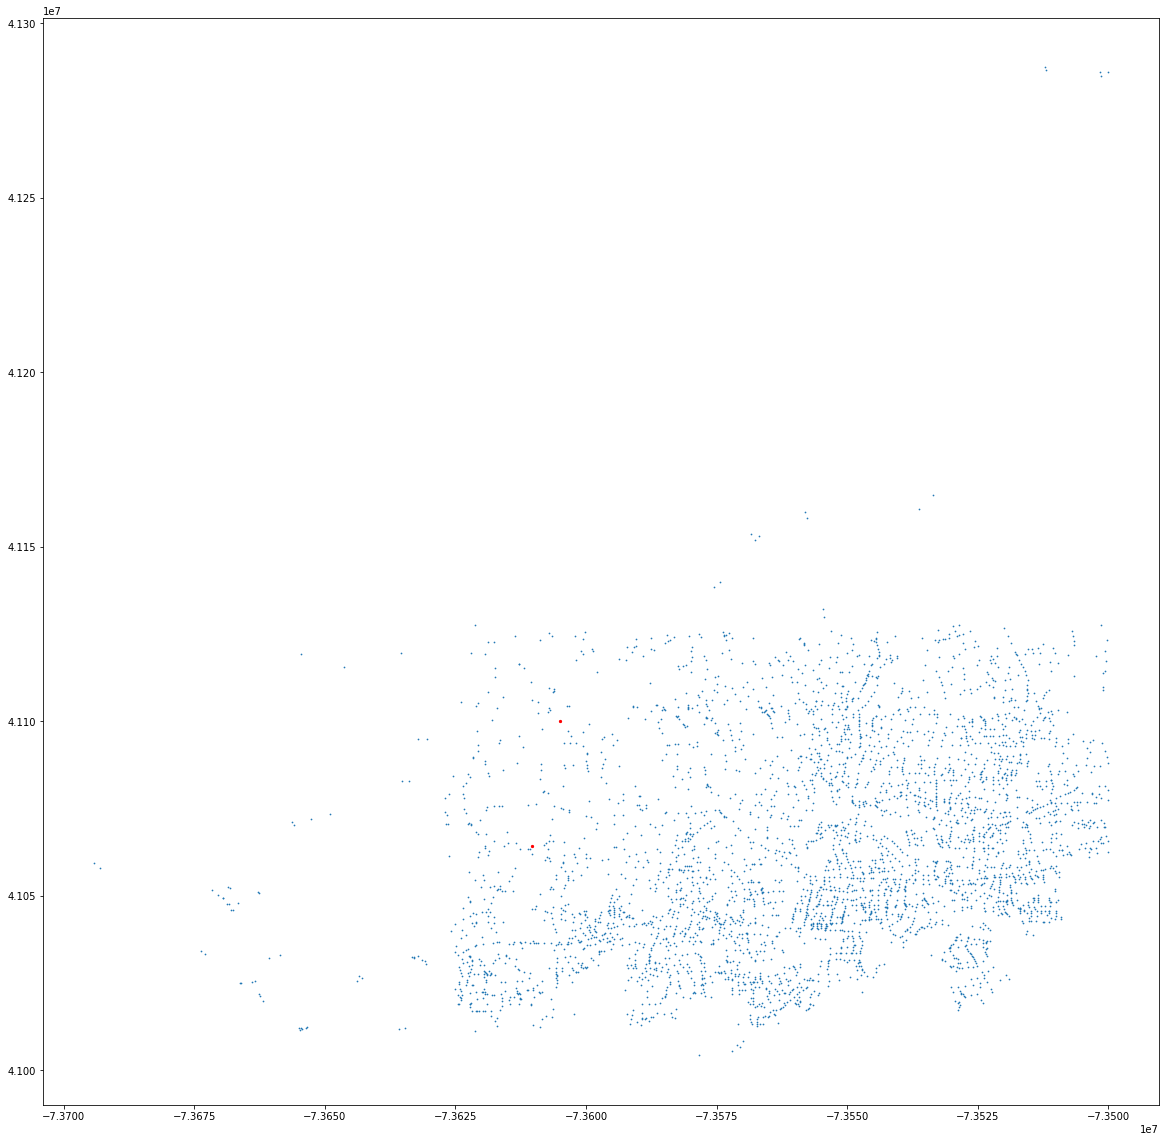

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.scatter(x_list,y_list,s=0.5)
""" for edge in dis_table[:1000]:
    x_1 = city_co[edge[0],1]
    x_2 = city_co[edge[1],1]
    X = [x_1, x_2]
    y_1 = city_co[edge[0],2]
    y_2 = city_co[edge[1],2]
    Y = [y_1, y_2]
    plt.plot(X, Y, color = 'r', linewidth = 0.1) """
# plt.savefig("map.png")
x_start = city_co[start,1]
x_target = city_co[target,1]
X = [x_start, x_target]
y_start = city_co[start,2]
y_target = city_co[target,2]
Y = [y_start, y_target]
plt.scatter(X,Y,c = 'r', s=5)
plt.show()

显示某一个节点有多少个邻居节点

In [44]:
for item in dis_table:
    #if item[0] <= 400 and item[1] <= 400:
    distance_adja_graph.addEdge(item[0],item[1],item[2])

In [100]:
node_nbr = list(distance_adja_graph.vertList[22].connectedTo)
for i in range(len(node_nbr)):
    print(node_nbr[i])

20connectedTo[21, 22, 4321]


开始测试搜索

In [13]:
initial_map(city_num)

In [14]:
initial_ants(start,target)

In [15]:
search_path(start,target)

found a path!
迭代次数： 1 最佳路径总距离： 18392 路径为： 196------205------209------208------203------204------253------254 搜索时长： 0.4438514709472656
迭代次数： 2 最佳路径总距离： 18392 路径为： 196------205------209------208------203------204------253------254 搜索时长： 0.41431617736816406
迭代次数： 3 最佳路径总距离： 18392 路径为： 196------205------209------208------203------204------253------254 搜索时长： 0.4295673370361328
迭代次数： 4 最佳路径总距离： 18392 路径为： 196------205------209------208------203------204------253------254 搜索时长： 0.4727468490600586
迭代次数： 5 最佳路径总距离： 18392 路径为： 196------205------209------208------203------204------253------254 搜索时长： 0.4469938278198242
迭代次数： 6 最佳路径总距离： 18392 路径为： 196------205------209------208------203------204------253------254 搜索时长： 0.44259142875671387
迭代次数： 7 最佳路径总距离： 18392 路径为： 196------205------209------208------203------204------253------254 搜索时长： 0.43636536598205566
迭代次数： 8 最佳路径总距离： 18392 路径为： 196------205------209------208------203------204------253------254 搜索时长： 0.4389772415161133
迭代次数： 9 最佳路径总距离： 18392 

KeyboardInterrupt: 

In [ ]:
start, target = 296,301
weight = abs(city_co[start,1] - city_co[target, 1]) + abs(city_co[start,2] - city_co[target, 2])
print(weight)